In [1]:
import cv2
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
import os # path
from glob import glob # search file paths
from tqdm.auto import tqdm # (optional) progress bar
from sklearn.model_selection import train_test_split

# PyTorch
import torch
from torch import nn
import torchvision
import torchvision.transforms as T
from torchsummary import summary # model summary

torch.__version__

'2.9.0+cu126'

In [2]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using: {device}")

Using: cuda


#### Download dataset

In [3]:
# download from google drive
!pip install --upgrade gdown
!gdown --fuzzy 1fIViA1w8MVJJZJcAjMwapHIYazuyTczE --output pneumonia.zip
# unzip dataset file
!unzip -q pneumonia.zip

Downloading...
From (original): https://drive.google.com/uc?id=1fIViA1w8MVJJZJcAjMwapHIYazuyTczE
From (redirected): https://drive.google.com/uc?id=1fIViA1w8MVJJZJcAjMwapHIYazuyTczE&confirm=t&uuid=9b43c4d5-5104-4b5a-814f-8a9b8d1e480a
To: /content/pneumonia.zip
100% 118M/118M [00:01<00:00, 101MB/s]


### Data

#### Check your data first

In [4]:
IMG_SIZE = 256 # 32x, 16x
all_class = ['normal', 'bacteria', 'virus']
class_map = {cls: i for i, cls in enumerate(all_class)}
#  'normal':0, 'bacteria': 1, 'virus':2
class_map

{'normal': 0, 'bacteria': 1, 'virus': 2}

In [5]:
# read all paths
# *: all
img_paths_train = sorted(glob('pneumonia/train/*/*.jpeg'))
img_paths_test = sorted(glob('pneumonia/val/*/*.jpeg'))

In [6]:
img_paths_train[:3]

['pneumonia/train/normal/IM-0158-0001.jpeg',
 'pneumonia/train/normal/IM-0164-0001.jpeg',
 'pneumonia/train/normal/IM-0199-0001.jpeg']

In [7]:
# number of images
len(img_paths_train), len(img_paths_test)

(150, 100)

pneumonia/train/pneumonia/person1010_virus_1695.jpeg
(307, 502, 3)


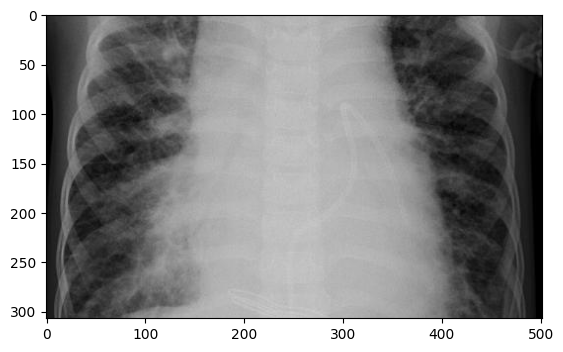

In [8]:
# show image
path = img_paths_train[100]
img = cv2.imread(path)
print(path)
print(img.shape)
plt.imshow(img)
plt.show()

In [9]:
# Extract img class
# os.sep: /
print(path)
print(path.split(os.sep))
cls = path.split(os.sep)[-2]
print(cls)

pneumonia/train/pneumonia/person1010_virus_1695.jpeg
['pneumonia', 'train', 'pneumonia', 'person1010_virus_1695.jpeg']
pneumonia


In [10]:
# Get file class index  路徑轉類別

# for pneumonia class
if cls == 'pneumonia':
    # get filename
    filename = path.split(os.sep)[-1]
    print(filename)
    # get pneumonia class
    cls_pneumonia = filename.split('_')[1]
    print(cls_pneumonia)
    cls_idx = class_map[cls_pneumonia]
    print(cls_idx)
# for normal class
else:
    cls_idx = class_map[cls]

person1010_virus_1695.jpeg
virus
2


In [11]:
cls_idx

2

#### Dataset & DataLoader


*   [torch.utils.data.Dataset](https://pytorch.org/docs/stable/data.html?highlight=dataset#torch.utils.data.Dataset)
繼承


*   Must implement  實作

    1.   **\_\_len\_\_()**: size of dataset
    計算有幾筆資料
    2.   **\_\_getitem\_\_()**: load a data sample for a given inde
    給資料

*   __getitem__() steps:
    1. Get image path
    2. Read image, resize
    3. Real image label
    4. convert image to tesnor and rescale to 0~1


ref: [Datasets & DataLoaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)


Pixel value rescale

*   0~1
*   -1~+1 : (x/127.5) - 1
* (x-x.mean()) / x.std()

In [12]:
#實作len 、getitem
#第一種寫法
class PneumoniaDataset(torch.utils.data.Dataset): #定義資料及名稱
    ''' Pneumonia dataset using OpenCV '''
    def __init__(self, img_paths, img_size, class_map): #給圖片路徑、大小、類別對照表
        self.img_paths = img_paths
        self.img_size = img_size
        self.class_map = class_map

    def __len__(self): #計算總共有幾筆資料
        """number of samples"""
        return len(self.img_paths)

    def __getitem__(self, idx):  #輸入索引值
        """read 1 sample"""
        # Read img
        path = self.img_paths[idx] # get img path
        img = cv2.imread(path) # read img
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB
        img = cv2.resize(img, (self.img_size, self.img_size)) # Resize iamge
        img = img / 255. # 0~255 -> 0.~1.  #numpy方式去轉成0~1

        # Read class index
        cls = path.split(os.sep)[-2]
        # for pneumonia class
        if cls == 'pneumonia':
            # get filename
            filename = path.split(os.sep)[-1]
            # get pneumonia class
            cls = filename.split('_')[1]
        cls_idx = self.class_map[cls]

        # transform img to tensor (轉乘張量的形式)
        img = torch.tensor(img, dtype=torch.float)
        # channel last -> channel first
        # np.swapaxis()
        img = img.permute(2, 0, 1) # (H, W, C) -> (C, H, W)
        # permute來轉換

        cls_idx = torch.tensor(cls_idx, dtype=torch.long)
        return img, cls_idx


#第二種寫法
class PneumoniaDataset(torch.utils.data.Dataset):
    ''' Pneumonia dataset using PIL.Image '''
    def __init__(self, img_paths, img_size, class_map):
        self.img_paths = img_paths
        self.img_size = img_size
        self.class_map = class_map
        self.transform = T.ToTensor()

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        # Read img
        path = self.img_paths[idx] # get img path
        img = Image.open(path).convert("RGB")
        img = img.resize((self.img_size, self.img_size))

        # Read class index
        cls = path.split(os.sep)[-2]
        # for pneumonia class
        if cls == 'pneumonia':
            # get filename
            filename = path.split(os.sep)[-1]
            # get pneumonia class
            cls = filename.split('_')[1]
        cls_idx = self.class_map[cls]

        # transform to tensor
        img = self.transform(img)
        cls_idx = torch.tensor(cls_idx, dtype=torch.long)

        return img, cls_idx

In [13]:
# Build dataset
train_ds = PneumoniaDataset(img_paths_train, IMG_SIZE, class_map)
val_ds = PneumoniaDataset(img_paths_test, IMG_SIZE, class_map)

In [14]:
# Number of samples: __len__
len(train_ds), len(val_ds)

(150, 100)

torch.Size([3, 256, 256]) tensor(0) normal


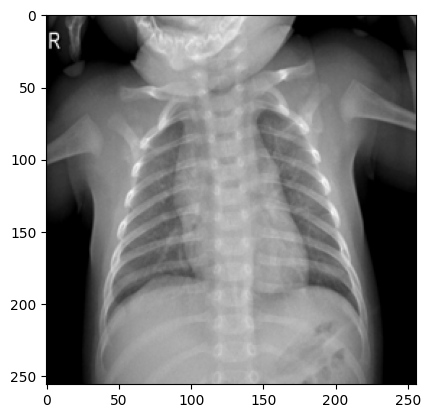

In [15]:
# __getitem__
img, label = train_ds[5] #中括號的方式直接取得第某筆資料
print(img.shape, label, all_class[label])

img = img.permute(1, 2, 0) # (C, H, W) -> (H, W, C) 通道在後
plt.imshow(img)
plt.show()

In [16]:
img, label

(tensor([[[0.0157, 0.0157, 0.0157],
          [0.0392, 0.0392, 0.0392],
          [0.1412, 0.1412, 0.1412],
          ...,
          [0.3412, 0.3412, 0.3412],
          [0.3020, 0.3020, 0.3020],
          [0.2980, 0.2980, 0.2980]],
 
         [[0.0078, 0.0078, 0.0078],
          [0.0431, 0.0431, 0.0431],
          [0.1451, 0.1451, 0.1451],
          ...,
          [0.3882, 0.3882, 0.3882],
          [0.3451, 0.3451, 0.3451],
          [0.3098, 0.3098, 0.3098]],
 
         [[0.0039, 0.0039, 0.0039],
          [0.0471, 0.0471, 0.0471],
          [0.1412, 0.1412, 0.1412],
          ...,
          [0.3647, 0.3647, 0.3647],
          [0.3804, 0.3804, 0.3804],
          [0.3294, 0.3294, 0.3294]],
 
         ...,
 
         [[0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000],
          [0

In [17]:
# Build DataLoaders
BATCH_SIZE = 32
train_loader = torch.utils.data.DataLoader(train_ds, BATCH_SIZE,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(val_ds, BATCH_SIZE)

In [18]:
for (x, y) in train_loader:
    print(x.shape, y.shape)
    print(y)
    break

torch.Size([32, 3, 256, 256]) torch.Size([32])
tensor([2, 1, 2, 1, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 2, 1, 0, 0, 0, 0, 0,
        2, 0, 0, 0, 0, 0, 1, 0])


### Model



*   Must implement
    1.   **\_\_init\_\_**(): layer **initialization**
    2.   **\_\_forward\_\_**(): connect **Input** to **Output**



*   Model architecture
    1.   Feature extractor (encoder)
    2.   Flatten
    3.   Classifier



In [19]:
kernel_size = 5   #通常會用奇數
model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=32,
        kernel_size=kernel_size,
        padding='same'),
    nn.ReLU(),
    nn.Conv2d(32, 32, kernel_size, padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2), # img_size/2

    nn.Conv2d(32, 64, kernel_size, padding='same'),
    nn.ReLU(),
    nn.Conv2d(64, 64, kernel_size, padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(2), # img_size/4

    nn.Conv2d(64, 128, kernel_size, padding='same'),
    nn.ReLU(),
    nn.Conv2d(128, 128, kernel_size, padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(2), # img_size/8

    nn.Conv2d(128, 256, kernel_size, padding='same'),
    nn.ReLU(),
    nn.Conv2d(256, 256, kernel_size, padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(2), # img_size/16

    nn.Flatten(), # C, H, W -> C*H*W

    nn.Linear(256*16*16, 3),

    # nn.Linear(256*16*16, 128),
    # nn.ReLU(),
    # nn.Linear(128, 3),
)

In [28]:
# Define Model class
class CNN(nn.Module):
    def __init__(self, kernel_size=3):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32,
                      kernel_size=kernel_size,
                      padding='same'),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # img_size/2

            nn.Conv2d(32, 64, kernel_size, padding='same'),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2), # img_size/4

            nn.Conv2d(64, 128, kernel_size, padding='same'),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2), # img_size/8

            nn.Conv2d(128, 256, kernel_size, padding='same'),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2), # img_size/16

            nn.Conv2d(256, 512, kernel_size, padding='same'),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2), # img_size/32
        )
        self.flatten = nn.Flatten() # (512, 8, 8) -> (512*8*8)
        self.classifier = nn.Sequential(
            nn.Linear(512*8*8, 128),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(128, 3), #輸出3
        )

    def forward(self, x):
        x = self.encoder(x) # img to feature maps
        x = self.flatten(x) # feature maps -> feature vectors
        x = self.classifier(x) # classification
        return x

In [29]:
# Build a model and move to GPU device
model = CNN(kernel_size=3).to(device)

In [30]:
print(model)

CNN(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (6): ReLU()
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (11): ReLU()
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (16): ReLU()
    (17): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (18)

In [31]:
# Model summary
summary(model, (3, IMG_SIZE, IMG_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
              ReLU-2         [-1, 32, 256, 256]               0
            Conv2d-3         [-1, 32, 256, 256]           9,248
              ReLU-4         [-1, 32, 256, 256]               0
         MaxPool2d-5         [-1, 32, 128, 128]               0
            Conv2d-6         [-1, 64, 128, 128]          18,496
              ReLU-7         [-1, 64, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          36,928
              ReLU-9         [-1, 64, 128, 128]               0
        MaxPool2d-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 128, 64, 64]          73,856
             ReLU-12          [-1, 128, 64, 64]               0
           Conv2d-13          [-1, 128, 64, 64]         147,584
             ReLU-14          [-1, 128,

### Training

In [32]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=1e-2, # learning rate
)

In [33]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.train() # to training mode.
    epoch_loss, epoch_correct = 0, 0
    for batch_i, (x, y) in enumerate(tqdm(dataloader, leave=False)):
        x, y = x.to(device), y.to(device) # move data to GPU

        # zero the parameter gradients
        optimizer.zero_grad()

        # Compute prediction loss
        pred = model(x)
        loss = loss_fn(pred, y)

        # Optimization by gradients
        loss.backward() # backpropagation to compute gradients
        optimizer.step() # update model params

        # write to logs
        epoch_loss += loss.item() # tensor -> python value
        # (N, Class)
        epoch_correct += (pred.argmax(dim=1) == y).sum().item()

    # return avg loss of epoch, acc of epoch
    return epoch_loss/num_batches, epoch_correct/size


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.eval() # model to test mode.
    epoch_loss, epoch_correct = 0, 0

    # No gradient for test data
    with torch.no_grad():
        for batch_i, (x, y) in enumerate(dataloader):
            x, y = x.to(device), y.to(device)

            # Compute prediction loss
            pred = model(x)
            loss = loss_fn(pred, y)

            # write to logs
            epoch_loss += loss.item()
            epoch_correct += (pred.argmax(1) == y).sum().item()

    return epoch_loss/num_batches, epoch_correct/size

In [34]:
EPOCHS = 100
logs = {
    'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []
}
for epoch in tqdm(range(EPOCHS)):
    train_loss, train_acc = train(train_loader, model, loss_fn, optimizer)
    val_loss, val_acc = test(val_loader, model, loss_fn)

    print(f'EPOCH: {epoch:04d} \
    train_loss: {train_loss:.4f}, train_acc: {train_acc:.3f} \
    val_loss: {val_loss:.4f}, val_acc: {val_acc:.3f} ')

    logs['train_loss'].append(train_loss)
    logs['train_acc'].append(train_acc)
    logs['val_loss'].append(val_loss)
    logs['val_acc'].append(val_acc)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0000     train_loss: 1.0930, train_acc: 0.467     val_loss: 1.0957, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0001     train_loss: 1.0808, train_acc: 0.667     val_loss: 1.0943, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0002     train_loss: 1.0703, train_acc: 0.667     val_loss: 1.0933, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0003     train_loss: 1.0587, train_acc: 0.667     val_loss: 1.0925, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0004     train_loss: 1.0484, train_acc: 0.667     val_loss: 1.0920, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0005     train_loss: 1.0379, train_acc: 0.667     val_loss: 1.0918, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0006     train_loss: 1.0295, train_acc: 0.667     val_loss: 1.0919, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0007     train_loss: 1.0201, train_acc: 0.667     val_loss: 1.0922, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0008     train_loss: 1.0117, train_acc: 0.667     val_loss: 1.0929, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0009     train_loss: 0.9961, train_acc: 0.667     val_loss: 1.0939, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0010     train_loss: 0.9879, train_acc: 0.667     val_loss: 1.0954, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0011     train_loss: 0.9756, train_acc: 0.667     val_loss: 1.0975, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0012     train_loss: 0.9705, train_acc: 0.667     val_loss: 1.1000, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0013     train_loss: 0.9570, train_acc: 0.667     val_loss: 1.1032, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0014     train_loss: 0.9434, train_acc: 0.667     val_loss: 1.1073, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0015     train_loss: 0.9365, train_acc: 0.667     val_loss: 1.1122, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0016     train_loss: 0.9306, train_acc: 0.667     val_loss: 1.1177, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0017     train_loss: 0.9272, train_acc: 0.667     val_loss: 1.1238, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0018     train_loss: 0.9166, train_acc: 0.667     val_loss: 1.1309, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0019     train_loss: 0.9014, train_acc: 0.667     val_loss: 1.1395, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0020     train_loss: 0.9016, train_acc: 0.667     val_loss: 1.1480, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0021     train_loss: 0.8796, train_acc: 0.667     val_loss: 1.1591, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0022     train_loss: 0.8928, train_acc: 0.667     val_loss: 1.1680, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0023     train_loss: 0.8711, train_acc: 0.667     val_loss: 1.1793, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0024     train_loss: 0.8645, train_acc: 0.667     val_loss: 1.1920, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0025     train_loss: 0.8795, train_acc: 0.667     val_loss: 1.2004, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0026     train_loss: 0.8520, train_acc: 0.667     val_loss: 1.2137, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0027     train_loss: 0.8482, train_acc: 0.667     val_loss: 1.2263, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0028     train_loss: 0.8710, train_acc: 0.667     val_loss: 1.2312, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0029     train_loss: 0.8586, train_acc: 0.667     val_loss: 1.2387, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0030     train_loss: 0.8674, train_acc: 0.667     val_loss: 1.2430, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0031     train_loss: 0.8759, train_acc: 0.667     val_loss: 1.2439, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0032     train_loss: 0.8667, train_acc: 0.667     val_loss: 1.2480, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0033     train_loss: 0.8405, train_acc: 0.667     val_loss: 1.2570, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0034     train_loss: 0.8610, train_acc: 0.667     val_loss: 1.2589, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0035     train_loss: 0.8649, train_acc: 0.667     val_loss: 1.2590, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0036     train_loss: 0.8553, train_acc: 0.667     val_loss: 1.2616, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0037     train_loss: 0.8586, train_acc: 0.667     val_loss: 1.2639, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0038     train_loss: 0.8508, train_acc: 0.667     val_loss: 1.2682, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0039     train_loss: 0.8695, train_acc: 0.667     val_loss: 1.2678, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0040     train_loss: 0.8651, train_acc: 0.667     val_loss: 1.2674, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0041     train_loss: 0.8549, train_acc: 0.667     val_loss: 1.2716, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0042     train_loss: 0.8796, train_acc: 0.667     val_loss: 1.2653, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0043     train_loss: 0.8586, train_acc: 0.667     val_loss: 1.2688, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0044     train_loss: 0.8575, train_acc: 0.667     val_loss: 1.2702, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0045     train_loss: 0.8495, train_acc: 0.667     val_loss: 1.2745, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0046     train_loss: 0.8429, train_acc: 0.667     val_loss: 1.2800, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0047     train_loss: 0.8626, train_acc: 0.667     val_loss: 1.2784, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0048     train_loss: 0.8807, train_acc: 0.667     val_loss: 1.2727, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0049     train_loss: 0.8587, train_acc: 0.667     val_loss: 1.2750, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0050     train_loss: 0.8566, train_acc: 0.667     val_loss: 1.2777, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0051     train_loss: 0.8527, train_acc: 0.667     val_loss: 1.2796, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0052     train_loss: 0.8393, train_acc: 0.667     val_loss: 1.2851, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0053     train_loss: 0.8509, train_acc: 0.667     val_loss: 1.2867, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0054     train_loss: 0.8420, train_acc: 0.667     val_loss: 1.2912, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0055     train_loss: 0.8582, train_acc: 0.667     val_loss: 1.2888, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0056     train_loss: 0.8561, train_acc: 0.667     val_loss: 1.2874, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0057     train_loss: 0.8544, train_acc: 0.667     val_loss: 1.2879, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0058     train_loss: 0.8483, train_acc: 0.667     val_loss: 1.2900, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0059     train_loss: 0.8500, train_acc: 0.667     val_loss: 1.2899, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0060     train_loss: 0.8589, train_acc: 0.667     val_loss: 1.2876, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0061     train_loss: 0.8578, train_acc: 0.667     val_loss: 1.2871, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0062     train_loss: 0.8365, train_acc: 0.667     val_loss: 1.2945, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0063     train_loss: 0.8482, train_acc: 0.667     val_loss: 1.2964, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0064     train_loss: 0.8718, train_acc: 0.667     val_loss: 1.2894, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0065     train_loss: 0.8466, train_acc: 0.667     val_loss: 1.2918, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0066     train_loss: 0.8387, train_acc: 0.667     val_loss: 1.2970, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0067     train_loss: 0.8545, train_acc: 0.667     val_loss: 1.2955, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0068     train_loss: 0.8432, train_acc: 0.667     val_loss: 1.2974, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0069     train_loss: 0.8459, train_acc: 0.667     val_loss: 1.2985, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0070     train_loss: 0.8692, train_acc: 0.667     val_loss: 1.2924, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0071     train_loss: 0.8680, train_acc: 0.667     val_loss: 1.2893, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0072     train_loss: 0.8566, train_acc: 0.667     val_loss: 1.2889, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0073     train_loss: 0.8607, train_acc: 0.667     val_loss: 1.2875, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0074     train_loss: 0.8767, train_acc: 0.667     val_loss: 1.2817, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0075     train_loss: 0.8336, train_acc: 0.667     val_loss: 1.2901, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0076     train_loss: 0.8551, train_acc: 0.667     val_loss: 1.2886, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0077     train_loss: 0.8526, train_acc: 0.667     val_loss: 1.2891, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0078     train_loss: 0.8538, train_acc: 0.667     val_loss: 1.2919, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0079     train_loss: 0.8576, train_acc: 0.667     val_loss: 1.2895, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0080     train_loss: 0.8654, train_acc: 0.667     val_loss: 1.2881, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0081     train_loss: 0.8441, train_acc: 0.667     val_loss: 1.2917, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0082     train_loss: 0.8703, train_acc: 0.667     val_loss: 1.2864, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0083     train_loss: 0.8551, train_acc: 0.667     val_loss: 1.2878, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0084     train_loss: 0.8683, train_acc: 0.667     val_loss: 1.2848, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0085     train_loss: 0.8618, train_acc: 0.667     val_loss: 1.2851, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0086     train_loss: 0.8442, train_acc: 0.667     val_loss: 1.2904, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0087     train_loss: 0.8657, train_acc: 0.667     val_loss: 1.2880, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0088     train_loss: 0.8546, train_acc: 0.667     val_loss: 1.2891, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0089     train_loss: 0.8387, train_acc: 0.667     val_loss: 1.2945, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0090     train_loss: 0.8516, train_acc: 0.667     val_loss: 1.2960, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0091     train_loss: 0.8473, train_acc: 0.667     val_loss: 1.2973, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0092     train_loss: 0.8479, train_acc: 0.667     val_loss: 1.2981, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0093     train_loss: 0.8697, train_acc: 0.667     val_loss: 1.2911, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0094     train_loss: 0.8581, train_acc: 0.667     val_loss: 1.2913, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0095     train_loss: 0.8589, train_acc: 0.667     val_loss: 1.2892, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0096     train_loss: 0.8425, train_acc: 0.667     val_loss: 1.2941, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0097     train_loss: 0.8520, train_acc: 0.667     val_loss: 1.2949, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0098     train_loss: 0.8626, train_acc: 0.667     val_loss: 1.2929, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0099     train_loss: 0.8522, train_acc: 0.667     val_loss: 1.2941, val_acc: 0.500 


#### Logs

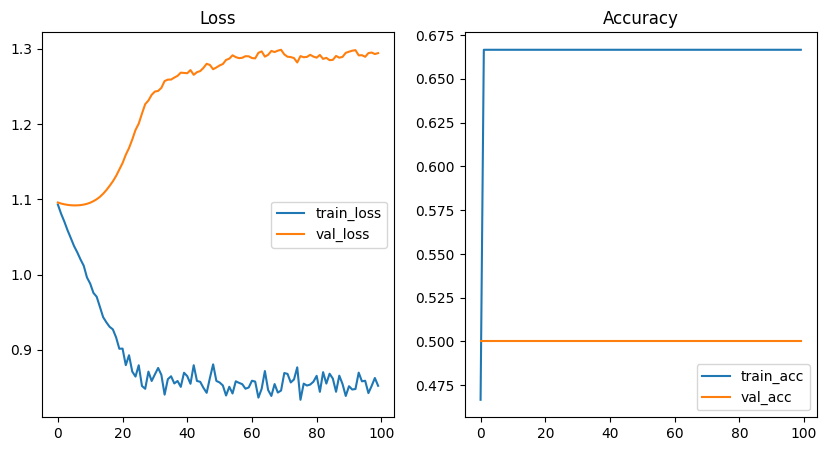

In [35]:
# Plot loss curve
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(logs['train_loss'])
plt.plot(logs['val_loss'])
plt.legend(['train_loss', 'val_loss'])
# plot acc
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(logs['train_acc'])
plt.plot(logs['val_acc'])
plt.legend(['train_acc', 'val_acc'])
plt.show()

#### Evaluation




In [36]:
model = model.to(device) # move model to GPU
model.eval() # Set model to evaluation mode
# Create temp tensor
y_true = torch.tensor([], dtype=torch.long).to(device)
y_pred_logits = torch.tensor([]).to(device)

# deactivate autograd engine and reduce memory usage and speed up computations
with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)

        pred = model(x)
        # Concatenate Ground truth and prediction
        y_true = torch.cat((y_true, y), dim=0)
        y_pred_logits = torch.cat((y_pred_logits, pred), dim=0)

y_pred_cls = y_pred_logits.argmax(1) # get class idx with max prob (100, 3) -> (100, )
y_pred_probs = torch.nn.functional.softmax(y_pred_logits, dim=1) # convert logits to probability

# Move tensor to CPU and convert to np.ndarray
y_true = y_true.cpu().numpy()
y_pred_cls = y_pred_cls.cpu().numpy()
y_pred_probs = y_pred_probs.cpu().numpy()


In [37]:
# Shape
y_true.shape, y_pred_probs.shape, y_pred_cls.shape

((100,), (100, 3), (100,))

In [38]:
# calculate ACC.
acc = sum(y_true == y_pred_cls) / len(y_true)
acc

np.float64(0.5)